                                            GROUP1
                        Exploratory Data Analysis on Graduate Admission Dataset
Team Members: 
Hrishikesh Suvarna,
Phaneesha chilaveni,
Shiva Jyothika, 
Savitri Vemparala

Problem stmnt:
Currently students are facing difficulties in applying for the right universities that suits their profile with less chances of rejection. As every university have their set of parameters to accept student application, it becomes difficult for a student to understand the probability of acceptance.
The main objective of this project is to visualise and determine the significance of each parameter and predict the admit chances of a candidate based on certain parameters.


Importing all the required libraries for the analysis on the data

In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import sqlite3
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

Creating a Database "dbfile.db" and populating tables- GRADADMIT , TESTSCORES from the data fetched from .csv files.

In [2]:

connec=sqlite3.connect("dbfile.db",True)
cursor=connec.cursor()
cursor.execute('''CREATE TABLE IF NOT EXISTS GRADADMIT(
    GRE_Score INT,
    TOEFL_Score INT,
    University_ranking INT,
    SOP DECIMAL,
    LOR DECIMAL,
    CGPA DECIMAL,
    Research INT,
    Chance_of_admit DECIMAL)''')

df = pd.read_csv("/Users/phanee/Downloads/Python Project/Admission_Predict_Ver1.1.csv")
for index,row in df.iterrows():
    cursor.execute('INSERT INTO GRADADMIT(GRE_Score,TOEFL_Score,University_ranking,SOP,LOR,CGPA,Research,Chance_of_admit) VALUES (?,?,?,?,?,?,?,?)',list((row['GRE Score']
                                                                         ,row['TOEFL Score'],
                                                                         row['University Rating'],
                                                                         row['SOP'],row['LOR '],
                                                                         row['CGPA'],row['Research'],
                                                                         row['Chance of Admit ']*100)))
connec.commit()
sql_statement = 'SELECT * FROM GRADADMIT'
sample = pd.read_sql_query(sql_statement,connec)
sample

,GRE_Score,TOEFL_Score,University_ranking,SOP,LOR,CGPA,Research,Chance_of_admit
0,337,118,4,4.5,4.5,9.65,1,92.0
1,324,107,4,4.0,4.5,8.87,1,76.0
2,316,104,3,3.0,3.5,8.00,1,72.0
3,322,110,3,3.5,2.5,8.67,1,80.0
4,314,103,2,2.0,3.0,8.21,0,65.0
...,...,...,...,...,...,...,...,...
995,332,108,5,4.5,4.0,9.02,1,87.0
996,337,117,5,5.0,5.0,9.87,1,96.0
997,330,120,5,4.5,5.0,9.56,1,93.0
998,312,103,4,4.0,5.0,8.43,0,73.0


Plotting correlation plot to find the relation among all the variables.

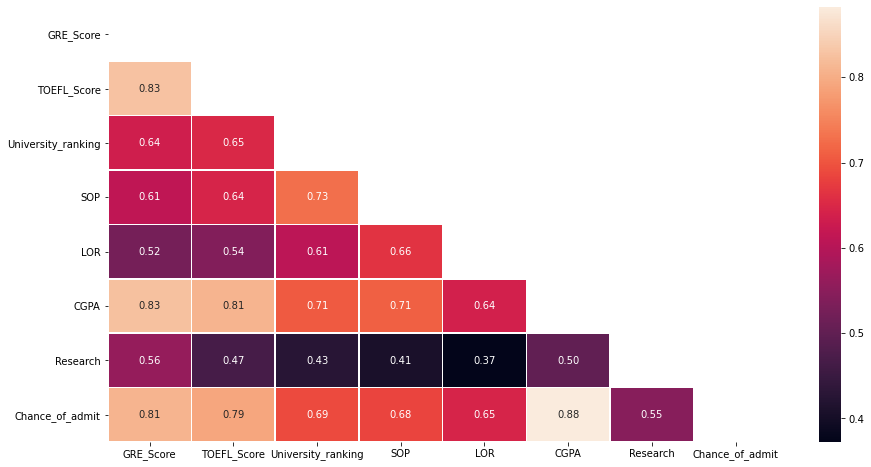

In [3]:
corr = sample.corr()
fig, ax = plt.subplots(figsize=(15, 8))
dropSelf = np.zeros_like(corr)
dropSelf[np.triu_indices_from(dropSelf)] = True
sns.heatmap(corr, linewidths=.5, annot=True, fmt=".2f", mask=dropSelf)
plt.show()

Inferences from the above correlation plot:

We can observe that CGPA, GRE score and TOEFL score are the top most factors influencing the chance of admit.




This below bar graph illustrates the distribution of students based on their GRE scores.

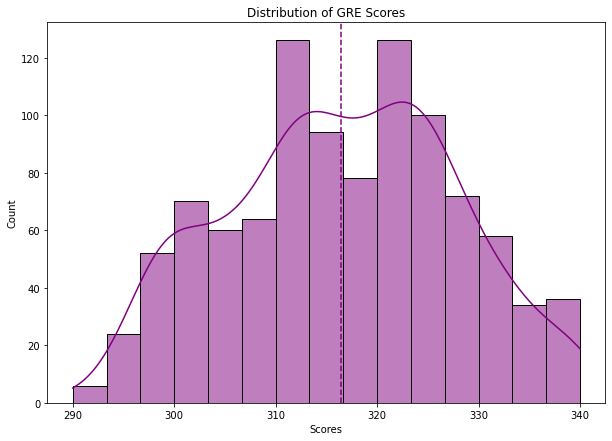

316.472


In [4]:
fig,ax=plt.subplots(figsize = (10,7))
sns.histplot(sample['GRE_Score'],kde=True,color='purple',ax=ax)
mean=sample['GRE_Score'].mean()
ax.axvline(mean, color='purple', linestyle='--')
plt.title('Distribution of GRE Scores')
plt.xlabel('Scores')
plt.show()
print(mean)

We could observe that most of the students scores are in the range of 310- 325 and a average score of 316.47

Similarly this below bar graph explains the distribution of students based on their TOEFL score.

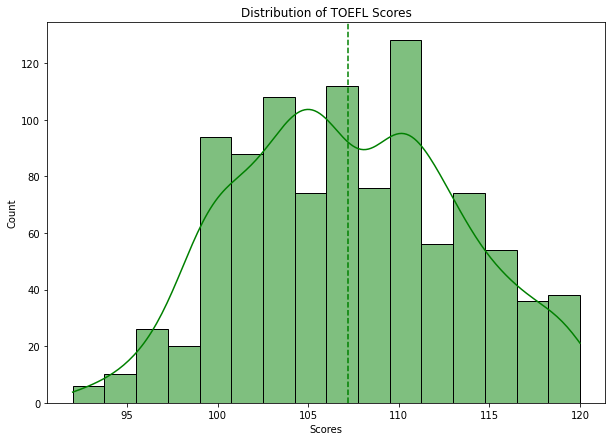

107.192


In [5]:
fig,ax=plt.subplots(figsize = (10,7))
sns.histplot(sample['TOEFL_Score'],kde=True,color='green',ax=ax)
mean=sample['TOEFL_Score'].mean()
ax.axvline(mean, color='green', linestyle='--')
plt.title('Distribution of TOEFL Scores')
plt.xlabel('Scores')
plt.show()
print(mean)

We can observe that most of the students TOEFL score varies from 100 to 112 and average score being 107.

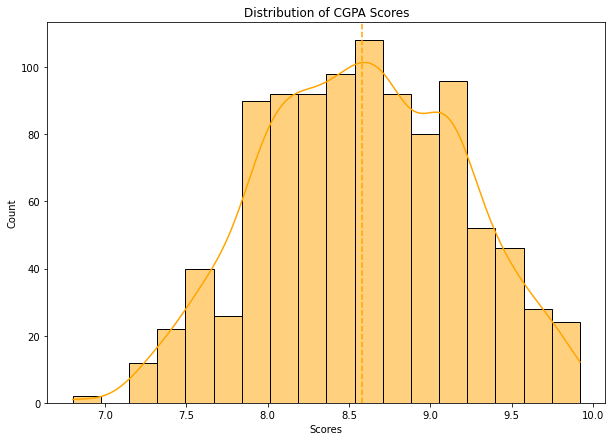

8.576440000000003


In [6]:
fig,ax=plt.subplots(figsize = (10,7))
sns.histplot(sample['CGPA'],kde=True,color='orange',ax=ax)
mean=sample['CGPA'].mean()
ax.axvline(mean, color='orange', linestyle='--')
plt.title('Distribution of CGPA Scores')
plt.xlabel('Scores')
plt.show()
print(mean)

Creating TESTSCORES table containing GRE Score,TOEFL Score,CGPA and chance of admit

In [7]:
total = 0.81+0.78+0.88
cursor.execute('''CREATE TABLE IF NOT EXISTS TESTSCORES(
    GRE_Score INT,
    TOEFL_Score INT,
    CGPA DECIMAL,
    Chance_of_admit DECIMAL
    )''')

sql_statement = """SELECT GRE_Score,
    TOEFL_Score,
    CGPA ,
    Chance_of_admit,
    round((((0.81/{})*(GRE_Score-260)*100/80)+
    ((0.78/{})*(TOEFL_Score)*100/120)+
    ((0.88/{})*(CGPA)*100/10))/3,2) AS Total

    FROM GRADADMIT""".format(total,total,total)
test = pd.read_sql_query(sql_statement,connec)
    
    


Inserting. new column named Total. Considereed scaled averages of GRE score,TOEFL Score,CGPA.

In [8]:

test['Total'] = round((test['Total']-test['Total'].min())/(test['Total'].max() -test['Total'].min())*100,2)

In [9]:
test

,GRE_Score,TOEFL_Score,CGPA,Chance_of_admit,Total
0,337,118,9.65,92.0,92.26
1,324,107,8.87,76.0,61.02
2,316,104,8.00,72.0,40.77
3,322,110,8.67,80.0,58.98
4,314,103,8.21,65.0,39.74
...,...,...,...,...,...
995,332,108,9.02,87.0,72.60
996,337,117,9.87,96.0,93.79
997,330,120,9.56,93.0,84.68
998,312,103,8.43,73.0,39.66


Plotting scatter plot between the total and chance of admit to check the relation.

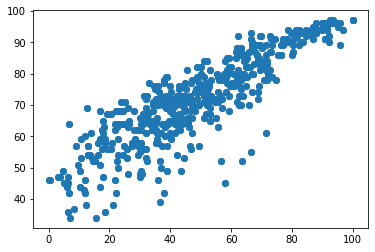

In [10]:

plt.scatter('Total','Chance_of_admit',data = test)
plt.show()

<AxesSubplot:>

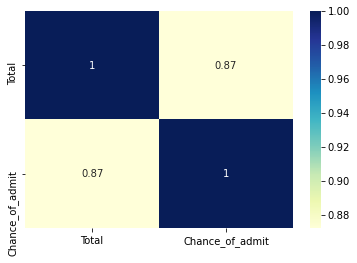

In [11]:
corr_tc = (test[['Total','Chance_of_admit']].corr())
corr_tc.iloc[0][1]
sns.heatmap(corr_tc,annot = True,cmap="YlGnBu")

<AxesSubplot:xlabel='Chance_of_admit', ylabel='Total'>

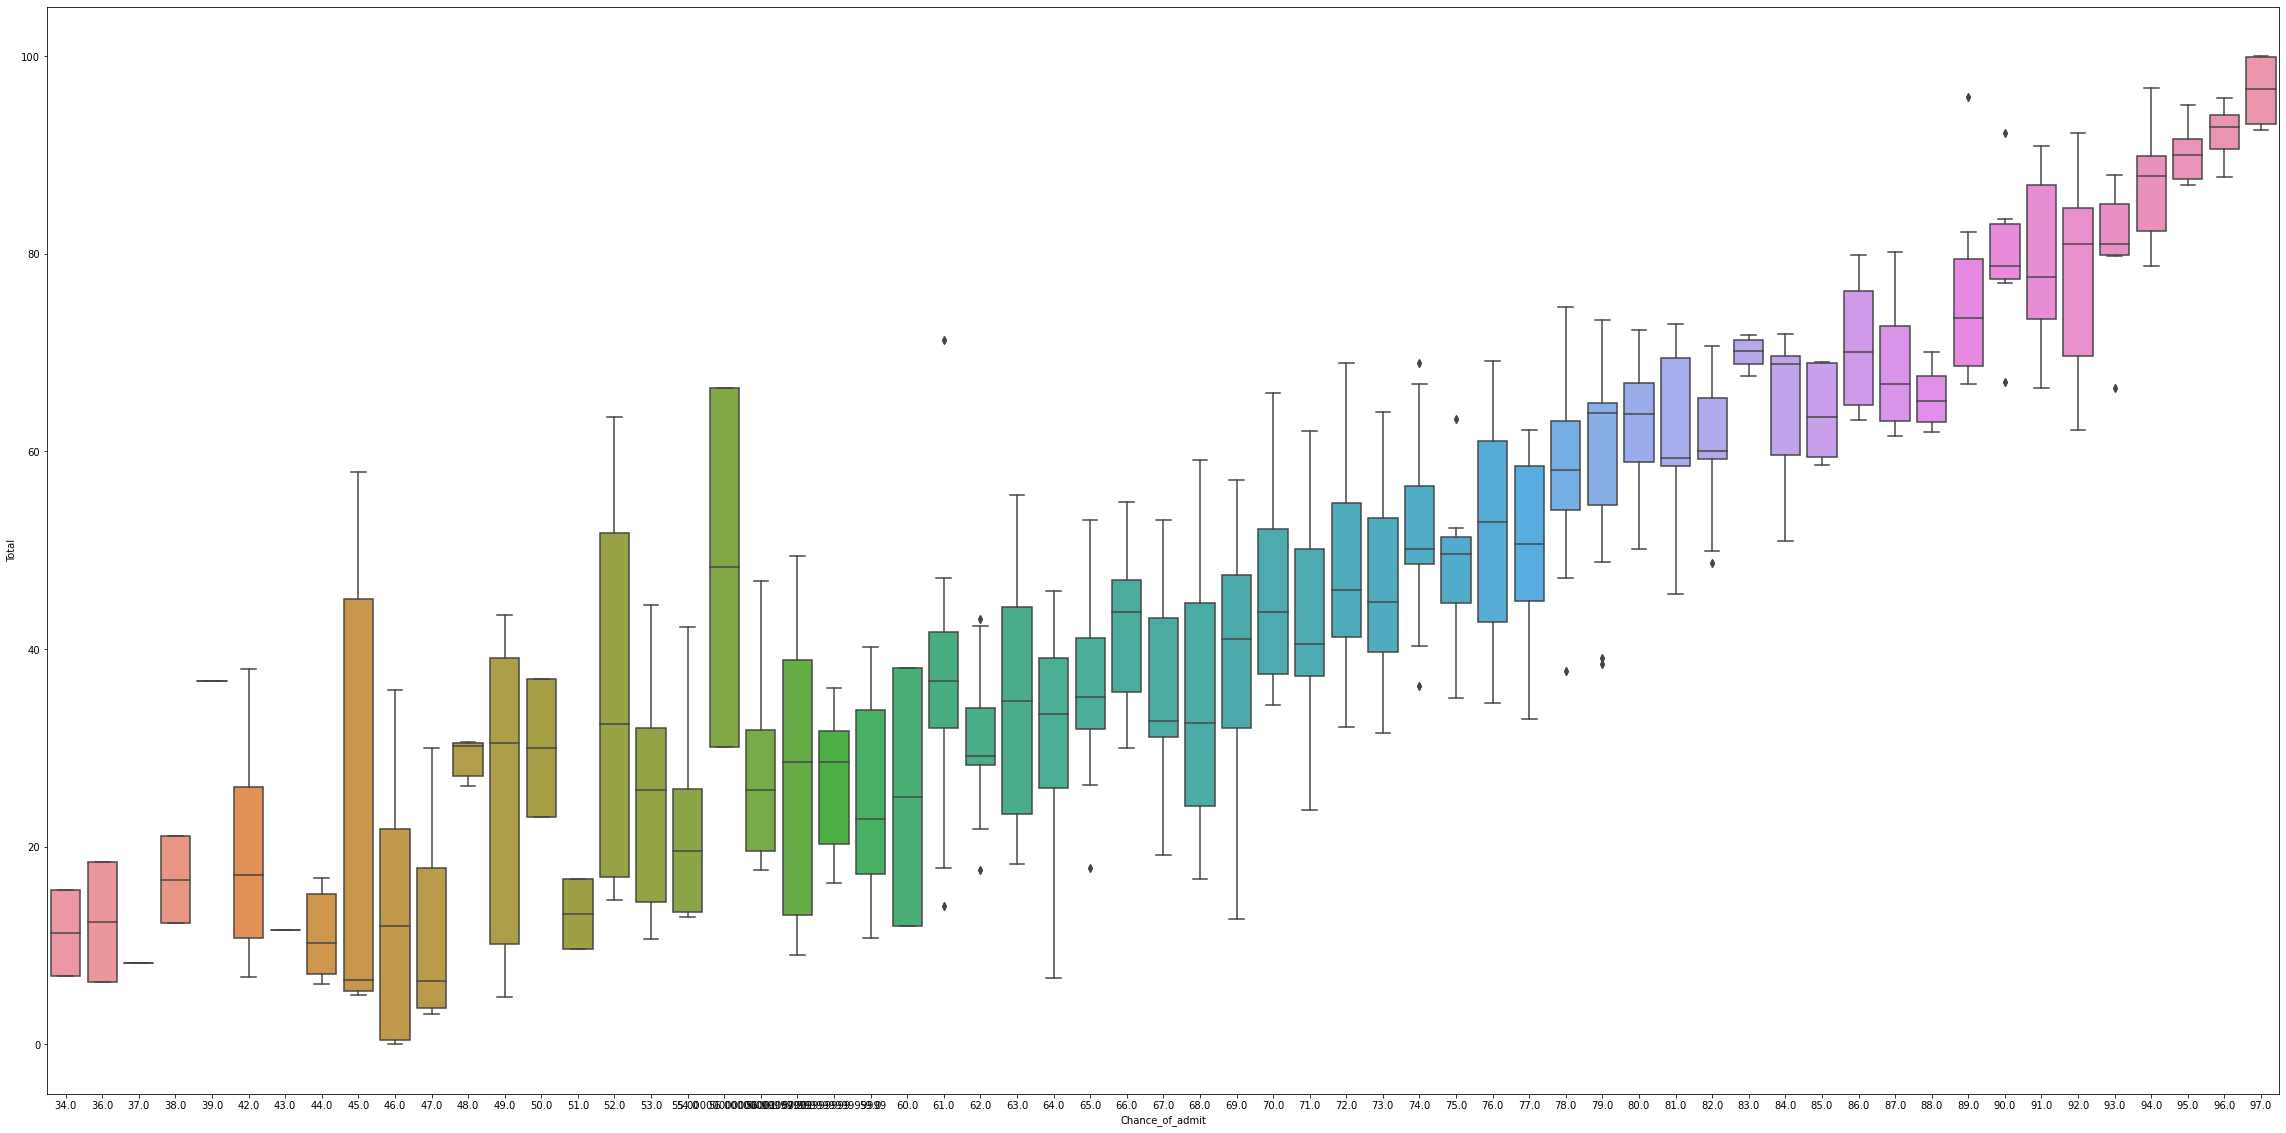

In [12]:
fig, ax = plt.subplots()
fig.set_size_inches(40, 20)
sns.boxplot(x="Chance_of_admit", y="Total", data=test,width=0.8)

Inference: we can see that total has high positive correlation with chance of admit having correlation coefficient of 0.87.

Plotting box plot between total and chance of admit. 

outliers can be observed in few of the box plots indicating the influence of other features like LOR,SOP and Research on the chance of admit.

Categorizing the chance of admit into Easy,Moderate,Difficult by adding a new column 'Admit Possibility' into the dataframe.

In [13]:
import warnings
warnings.filterwarnings("ignore")
test['Admit Possibility']=0
for i in range(0,len(test)):
    if(test['Chance_of_admit'][i]>75):
        test['Admit Possibility'][i]='Easy'
    elif(test['Chance_of_admit'][i]<55):
        test['Admit Possibility'][i]='Difficult'
    else:
        test['Admit Possibility'][i]='Moderate'

Plotting boxplot for Admit possibility and total 

<AxesSubplot:xlabel='Admit Possibility', ylabel='Total'>

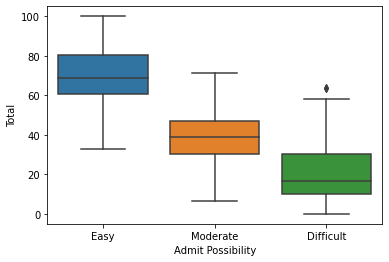

In [14]:
sns.boxplot(x = 'Admit Possibility',y = 'Total',data = test)

This boxplot suggests that applicants with higher total usually get into desired universities easier than the rest.


Plotting Histogram for Total and Admit possibility

<AxesSubplot:xlabel='Total', ylabel='Count'>

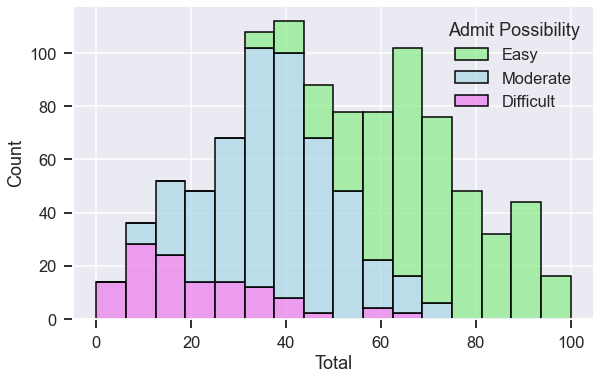

In [26]:
fig = plt.figure(figsize=(16,10))
colours=['lightgreen','lightblue','violet']
plt.subplot(2,2,1)
plt.style.use('seaborn')
plt.tight_layout()
sns.set_context('talk')
sns.histplot(data=test, x="Total", hue="Admit Possibility",multiple="stack",palette=colours)

This graph also supports the previous statement that applicants with higher total usually get into desired universities easier than the rest.


Swarm Plot

<AxesSubplot:xlabel='Admit Possibility', ylabel='Total'>

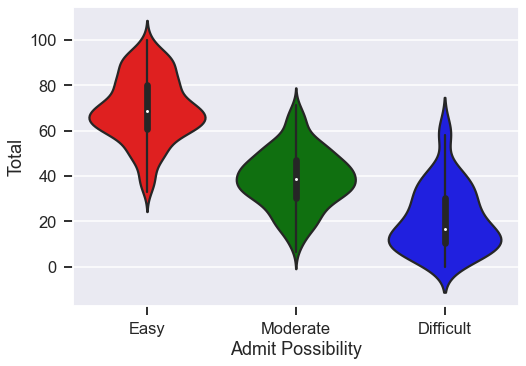

In [24]:
sns.violinplot(x="Admit Possibility",y="Total",data=test,palette = ['red','green','blue'])

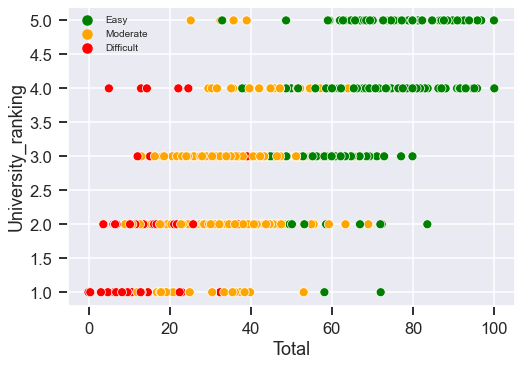

In [17]:
test['University_ranking'] = sample['University_ranking']
sns.scatterplot('Total','University_ranking',data = test,palette = ['green','orange','red'],hue = 'Admit Possibility')
plt.legend(loc = 'upper left',fontsize = 10)

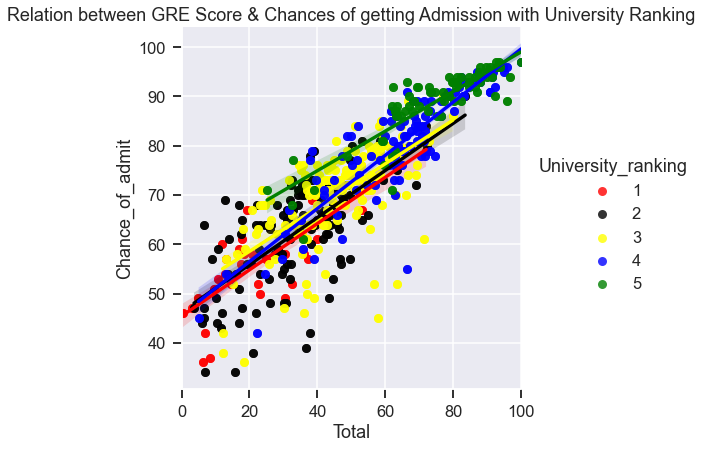

In [18]:

sns.lmplot(x = "Total",y = "Chance_of_admit",data = test,height=6,hue="University_ranking",palette = ['red','black','yellow','blue','green'])
plt.title("Relation between GRE Score & Chances of getting Admission with University Ranking")
plt.show()

Plotting scatter plot to show the influence of research on the chance of admit for different categories of university ranking.

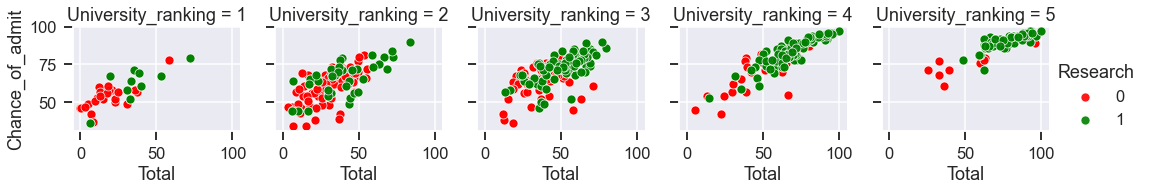

In [19]:
test['Research'] = sample['Research']
colours = ['red','green']
g = sns.FacetGrid(test, col="University_ranking",palette = colours, hue="Research")
g.map(sns.scatterplot, 'Total', "Chance_of_admit", alpha=.9)
g.add_legend()

This plot suggests that chances of admit are increased marginally for applicants with research papers.

Scatterplot to find number of applications to a university based on their totals.

For each university category we see that as the total increases probability of getting an admit also increases. A lot of green dots to the right and red dots to the left indicates that higher totals makes admits easier.

Convert the university ranking and research features as categorical for further manipulations on the data

In [20]:
sample[['University_ranking','Research']] = sample[['University_ranking','Research']].astype('category') 
sample.dtypes

GRE_Score                int64
TOEFL_Score              int64
University_ranking    category
SOP                    float64
LOR                    float64
CGPA                   float64
Research              category
Chance_of_admit        float64
dtype: object

Performing cross validation to find the model accuracy

In [21]:

# prepare the cross-validation procedure
cv = KFold(n_splits=5, random_state=1, shuffle=True)
# create model
model = linear_model.LinearRegression()
# evaluate model
scores = cross_val_score(model,sample.drop(['Chance_of_admit'],1,inplace = False),sample['Chance_of_admit'], scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# report performance
print(scores)
mse = [(i**2)/len(scores) for i in scores]
rmse = round((sum(mse))**0.5,2)
print('The root mean square error :',rmse)
print("The accuracy of the model is : ",100-rmse)


[-4.38638903 -4.34195398 -4.49575654 -4.09224129 -4.17135242]
The root mean square error : 4.3
The accuracy of the model is :  95.7


In [22]:
space = dict()
search = GridSearchCV(model, space, scoring='accuracy', n_jobs=-1, cv=cv, refit=True)
result = search.fit(sample.drop(['Chance_of_admit'],1,inplace = False), sample['Chance_of_admit'])




In [23]:

GRE =int(input("Enter GRE score: "))
while GRE not in range(260,341):
    print("Please enter valid GRE score")
    GRE = int(input("Enter GRE score :"))
    
TOEFL = int(input("Enter TOEFL score: "))
while TOEFL not in range(0,121):
    print("Please enter valid TOEFL score")
    TOEFL = int(input("Enter TOEFL score"))
    
SOP = float(input("Enter SOP rating: "))
while SOP not in [0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5]:
    print("Please enter valid SOP rating")
    SOP = float(input("Enter SOP rating: "))
    
LOR = float(input("Enter LOR rating: "))
while LOR not in [0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5]:
    print("Please enter valid LOR rating")
    LOR = float(input("Enter LOR rating: "))
    
CGPA = float(input("Enter CGPA: "))
while (CGPA<5 or CGPA>10) :
    print("Please enter valid CGPA score")
    CGPA = float(input("Enter CGPA: "))
    
Research = int(input("Enter Research value: "))
while Research not in [0,1]:
    print("Please enter valid Research value")
    Research = int(input("Enter Research value: "))
    
for i in range(1,6):
    University_ranking = i
    new_data = [(GRE,TOEFL,University_ranking,SOP,LOR,CGPA,Research)]

    new_array = np.asarray(new_data)
    prediction=result.predict(new_array)
    if prediction<0:
        print('chance of admit : 0%')
    else:
        print('for university rating : {} ,chance of admit : {}%'.format(i,round(prediction[0],2)))

Enter GRE score: 300
Enter TOEFL score: 100
Enter SOP rating: 4
Enter LOR rating: 2
Enter CGPA: 5
Enter Research value: 4
Please enter valid Research value
Enter Research value: 1
for university rating : 1 ,chance of admit : 22.19%
for university rating : 2 ,chance of admit : 22.78%
for university rating : 3 ,chance of admit : 23.37%
for university rating : 4 ,chance of admit : 23.97%
for university rating : 5 ,chance of admit : 24.56%


Calculated RMSE is 0.04 indicating 96% accurate model.


